# Multi-Fidelity Bayesian Optimization: Investigating a Minimal Toy Problem

(Inspired by "A Tutorial on Vanilla Bayesian Optimization" by Darian Nwankwo)

In [1]:
using Plots; plot() # warm start plotting engine
using LinearAlgebra
using Distributions
using Optim
using ForwardDiff

In [25]:
include("../src/mfbo.jl")

optimize_surrogate (generic function with 1 method)

## 1. Gather Initial Samples
Our first step is to run some initial experiments and collect our data locations into some matrix $X$ and observations into some vector $y$. Our "experiments" will be random evaluations of some test function; in practice, our function is black-boxed. Put these obervations into an nxd matrix X.

Test Function: GramacyLee


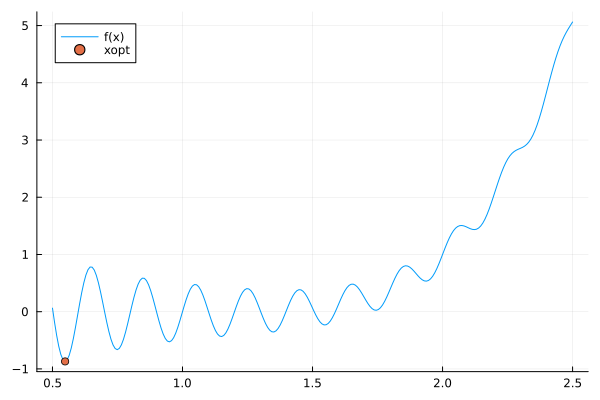

In [61]:
testfn, testfn_name, X, y =  get_toy_problem(N=4, fn_name = "GramacyLee")
println("Test Function: $(testfn_name)")
tplot(testfn)

## 2. Initialize surrogate model

Gather information regarding predictive mean and variance for our function. I will use kernels defined in kernels.jl.

In [27]:
#this will be changed so don't always
ψ = SquaredExponential(1.)

Node{Kernel}(Kernel([1.0], var"#squared_exponential#398"{Float64}(1.0), var"#squared_exponential_hypers#399"(), var"#326#332"{var"#squared_exponential#398"{Float64}}(var"#squared_exponential#398"{Float64}(1.0)), var"#328#334"{var"#squared_exponential#398"{Float64}}(var"#squared_exponential#398"{Float64}(1.0)), var"#330#336"{Vector{Float64}, var"#squared_exponential_hypers#399"}([1.0], var"#squared_exponential_hypers#399"()), SquaredExponentialConstructor, SquaredExponential, [1]), nothing, nothing)

In [28]:
sur = GP(ψ, X, y, noise = 1e-6)

GaussianProcess{Matrix{Float64}, Vector{Float64}, Float64}(Kernel([1.0], var"#squared_exponential#398"{Float64}(1.0), var"#squared_exponential_hypers#399"(), var"#326#332"{var"#squared_exponential#398"{Float64}}(var"#squared_exponential#398"{Float64}(1.0)), var"#328#334"{var"#squared_exponential#398"{Float64}}(var"#squared_exponential#398"{Float64}(1.0)), var"#330#336"{Vector{Float64}, var"#squared_exponential_hypers#399"}([1.0], var"#squared_exponential_hypers#399"()), SquaredExponentialConstructor, SquaredExponential, [1]), [1.659242593437586 1.7854951886435428 1.2786935061469378 1.0243425466617293], [1.000001 0.9920618162227024 0.9301505688792328 0.8174634925018526; 0.9920618162227024 1.000001 0.8794804244069694 0.7485055411095034; 0.9301505688792328 0.8794804244069694 1.000001 0.9681703698358639; 0.8174634925018526 0.7485055411095034 0.9681703698358639 1.000001], [1.000000499999875 0.0 0.0 0.0; 0.9920613201921663 0.12575904332721347 0.0 0.0; 0.9301501038042971 -0.3441940587714016 0

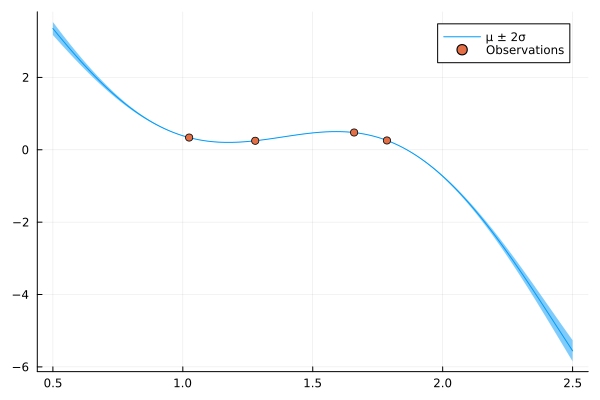

In [29]:
domain = first(testfn.bounds[:, 1]):0.01:first(testfn.bounds[:, 2])
plot1d(sur, interval = domain)

## 3. Construct Acquisition Function

Create some general acquisition functions for this step

In [30]:
af, af_name = get_random_acquisitionfn(sur)
plotaf1d(af, interval = domain)

LoadError: UndefKeywordError: keyword argument `lbs` not assigned

## 4. Optimize the acquisition function
Given our acquisition function, optimizing it directly. Thus, select the best location according to the chosen selection criteria.



In [31]:
# Consider taking all 4 acquisition functions, seeing their x values
# find the y values corresponding with these x values. Choose the AF
# which yields the highest y (as we are maximizing).
function optimize_acquisition_functions(sur::GaussianProcess, X::Vector{Float64}, y::Vector{Float64})
    xopt = 1.0
    lb, ub = minimum(X), maximum(X)
    best_val = -Inf
    best_fn = ""

    for (fn_name, fn) in get_acquisition_functions(sur)
        res = optimize(
            x -> -fn.f(x),
            lb,
            ub
        )
        val = -Optim.minimum(res)  # Minimize negative to maximize
        if val > best_val
            best_val = val
            xopt = Optim.minimizer(res)[1]
            best_fn = fn_name
        end
    end

    println("Optimal x: ", xopt)
    println("Optimal value: ", best_val)
    println("Best acquisition function: ", best_fn)
    return xopt
end

optimize_acquisition_functions (generic function with 1 method)

In [36]:
lbs_ = testfn.bounds[:, 1]
ubs_ = testfn.bounds[:, 2]
EIx=EI(sur, lbs=lbs_, ubs=ubs_)
Xopt=optimize_acquisition(EIx)

1-element Vector{Float64}:
 2.499999999835707

## 5. Sample data at new recommendation

In [42]:
# Referenced from Darian's code... still unsure about this part
X_1, y_1 = Xopt, testfn.f(Xopt)
sur = schur_update(sur, X_1, y_1)

GaussianProcess{Matrix{Float64}, Vector{Float64}, Float64}(Kernel([1.0], var"#squared_exponential#398"{Float64}(1.0), var"#squared_exponential_hypers#399"(), var"#326#332"{var"#squared_exponential#398"{Float64}}(var"#squared_exponential#398"{Float64}(1.0)), var"#328#334"{var"#squared_exponential#398"{Float64}}(var"#squared_exponential#398"{Float64}(1.0)), var"#330#336"{Vector{Float64}, var"#squared_exponential_hypers#399"}([1.0], var"#squared_exponential_hypers#399"()), SquaredExponentialConstructor, SquaredExponential, [1]), [1.659242593437586 1.7854951886435428 … 2.499999999835707 1.4413421790998744], [1.000001 0.9920618162227024 … 0.7022705795911144 0.9765392886870267; 0.9920618162227024 1.000001 … 0.7747161594312378 0.9424987866931881; … ; 0.7022705795911144 0.7747161594312378 … 1.000001 0.570993078735998; 0.9765392886870267 0.9424987866931881 … 0.570993078735998 1.000001], [1.000000499999875 0.0 … 0.0 0.0; 0.9920613201921663 0.12575904332721347 … 0.0 0.0; … ; 0.7022702284560879 0.

In [43]:
EIx=EI(sur, lbs=lbs_, ubs=ubs_)
Xopt=optimize_acquisition(EIx)

1-element Vector{Float64}:
 1.5537318553045432

## 6. Repeat until budget exhausted and provide final recommendation.

In [65]:
for i=1:100
    EIx=EI(sur, lbs=lbs_, ubs=ubs_)
    Xopt=optimize_acquisition(EIx)
    X_1, y_1 = Xopt, testfn.f(Xopt)
    sur = schur_update(sur, X_1, y_1)
end

In [66]:
Xopt

1-element Vector{Float64}:
 1.4934845864679096

In [67]:
y_1

0.12735481141923544